<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Otimizando o Modelo de IA Para  Prever a Capacidade com Stacked LSTM</font></b></strong>

No modelo anterior criamos nosso primeiro modelo de Deep Learning para a Previsão da Capacidade. Agora vamos trabalhar na otimização do modelo e começaremos com um modelo Stacked LSTM.

**Deep Learning - Modelo Stacked LSTM**

O Modelo Stacked LSTM nada mais é do que um Modelo com mais de uma camada LSTM. A camada LSTM é o diferencial do modelo e adicionando mais uma camada esperamos aumentar o poder de acurácia do modelo final.

Vamos discutir ainda como calcular o número de neurônios em cada camada. 

Este modelo considera algum conhecimento em Deep Learning e esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [ ]:
# Imports para modelagem preditiva - Tensorflow 1.
#import keras
#from keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
#from keras.layers.core import Dense, Activation
#from keras.layers import LSTM
#from keras.layers import Dropout

In [2]:
# Imports para modelagem preditiva - Tensorflow 2.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

pandas           1.0.5
matplotlib       3.2.2
tensorflow.keras 2.1.6-tf
numpy            1.16.6
statsmodels      0.11.1
statsmodels.api  0.11.1
sklearn          0.23.1
tensorflow       1.10.0
seaborn          0.10.1
Data Science Academy


## Definição do Problema de Negócio

Previsão do distanciamento social em Minas Gerais.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o distanciamento social em Minas Gerais. Os dados tem registros de 15/02/2020 a 29/01/2021.

Será fornecido 1 dataset com 2 colunas, data e distanciamento social.

In [4]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [5]:
# Dados
dataframe.head()

,QT_INTER
Data,
2020-02-15,31.6
2020-02-16,38.9
2020-02-17,24.0
2020-02-18,26.5
2020-02-19,27.8


In [6]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['QT_INTER']

In [7]:
# Random seed 
np.random.seed(7)

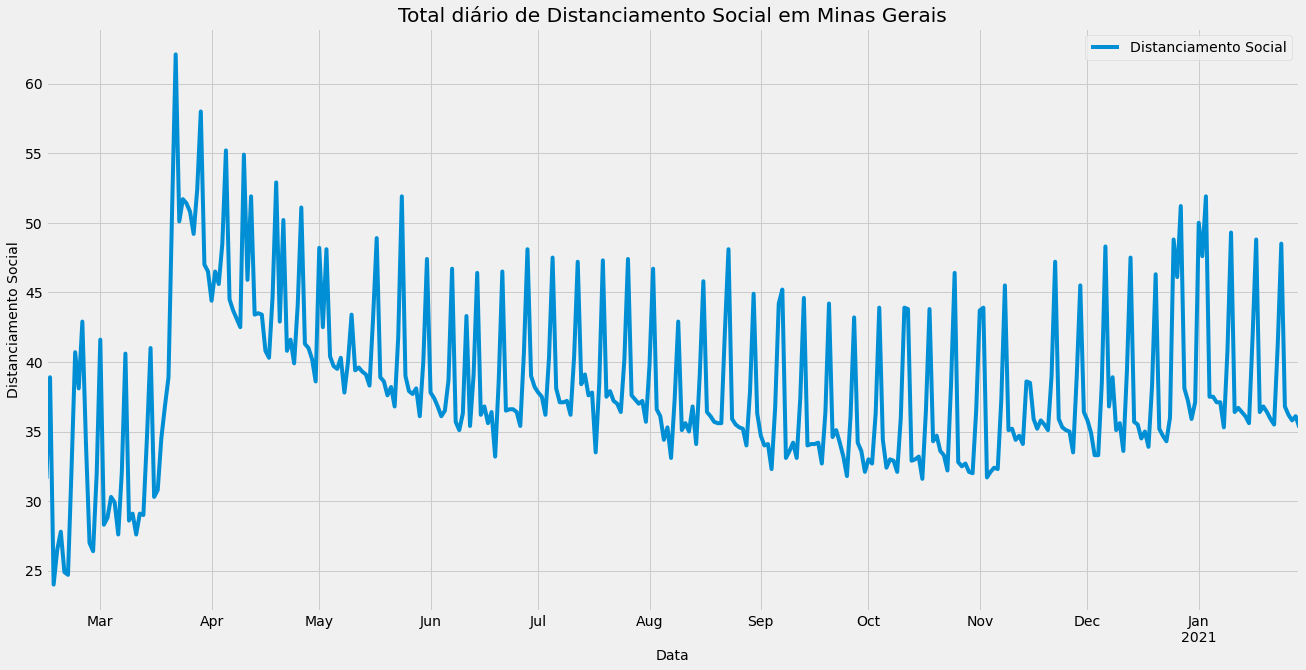

In [8]:
# Plot
target.plot(title = 'Total diário de Distanciamento Social em Minas Gerais', fontsize = 14, label = 'Distanciamento Social') 
plt.xlabel("Data") 
plt.ylabel("Distanciamento Social") 
plt.legend(loc = 'best') 
plt.show()

In [9]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

262 88


In [10]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.values.reshape(-1,1)
testset = teste.values.reshape(-1,1)

### Função Para o Cálculo da Acurácia

In [11]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo Stacked LSTM

A rede Long Short-Term Memory, ou LSTM, é uma rede neural recorrente treinada usando Backpropagation Through Time e supera o problema da dissipação do gradiente (isso é explicado no Deep Learning Book).

Como tal, o modelo pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.

Podemos alterar a arquitetura do modelo e adicionar mais uma camada LSTM, aumentando assim a capacidade de previsão do modelo.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entre 0 e 1. O parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intevalo será entre 0 e 1.

In [12]:
# Cria o scaler para dimensionar nossos dados entre 0 e 1
scaler = MinMaxScaler()

In [13]:
# Treina o scaler nos dados de treino (nunca no dataset completo ou nos dados de teste)
scaler.fit(trainset)

MinMaxScaler()

In [14]:
# Aplica o mesmo scaler aos dados de treino 
# (Não precisamos aplicar aos dados de teste, pois vamos converter a saída das previsões antes de avaliar o modelo)
trainset = scaler.transform(trainset)

In [15]:
trainset.shape

(262, 1)

Aqui definimos os hiperparâmetros.

In [16]:
# Número de repetições
n_rep = 5

# Número de epochs
num_epochs = 200

# Número de inputs (usaremos 88 séries para prever as 88 séries seguintes)
n_input = 88

# Comprimento das sequências de saída (em número de timesteps)
n_output = 88

# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 10

O TimeseriesGenerator do Keras transforma automaticamente um conjunto de dados univariado de séries temporais em um dataset para problema de aprendizado supervisionado.

https://keras.io/preprocessing/sequence/

In [17]:
# Generator
generator = TimeseriesGenerator(trainset, 
                                trainset, 
                                length = n_output,
                                batch_size = size_batch)

Podemos agora criar o modelo Stacked LSTM.

Detalhes sobre os hiperparâmetros aqui:

https://keras.io/layers/recurrent/

In [18]:
# Criação e treinamento do modelo LSTM Padrão
start = time()

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Podemos adicionar agora a primeira camada da rede, ou camada de entrada.
    # Esta é a camada que recebe os dados.
    # Como vamos criar uma arquitetura de camadas LSTM em pilha, precisamos adicionar o parâmetro:
    # return_sequences = True, indicando que esta camada deve retornar uma sequência que será usada
    # como entrada na próxima camada LSTM
    modelo_lstm.add(LSTM(40, activation = 'tanh', return_sequences = True, input_shape = (n_input, n_features)))
    
    # Mais uma camada LSTM
    modelo_lstm.add(LSTM(40, activation = 'relu'))
    
    # Adicionamos a primeira camada intermediária ou oculta
    modelo_lstm.add(Dense(50, activation = 'relu'))
    
    # Adicionamos a segunda camada intermediária ou oculta
    modelo_lstm.add(Dense(50, activation = 'relu'))
    
    # Adicionamos a camada de saída e tudo que precisamos é de 1 neurônio pois estamos prevendo apenas 1 valor.
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    # adam = optimizers.Adam(learning_rate = 0.001)
    adam = optimizers.Adam(lr = 0.001)
    modelo_lstm.compile(optimizer = adam, loss = 'mean_squared_error')
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = target[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/200
18/18 [==============================] - 15s 832ms/step - loss: 0.0853
Epoch 2/200
18/18 [==============================] - 11s 584ms/step - loss: 0.0144
Epoch 3/200
18/18 [==============================] - 11s 584ms/step - loss: 0.0128
Epoch 4/200
18/18 [==============================] - 10s 579ms/step - loss: 0.0125
Epoch 5/200
18/18 [==============================] - 11s 596ms/step - loss: 0.0125
Epoch 6/200
18/18 [==============================] - 11s 593ms/step - loss: 0.0126
Epoch 7/200
18/18 [==============================] - 11s 615ms/step - loss: 0.0126
Epoch 8/200
18/18 [==============================] - 12s 670ms/step - loss: 0.0125
Epoch 9/200
18/18 [==============================] - 12s 670ms/step - loss: 0.0125
Epoch 10/200
18/18 [==============================] - 11s 589ms/step - loss: 0.0125
Epoch 11/200
18/18 [==============================] - 10s 581ms/step - loss: 0.0128
Epoch 12/200
18/18 [==============================] - 10s 576ms/step - loss: 0.0127
E

18/18 [==============================] - 10s 576ms/step - loss: 0.0040
Epoch 99/200
18/18 [==============================] - 10s 573ms/step - loss: 0.0032
Epoch 100/200
18/18 [==============================] - 10s 575ms/step - loss: 0.0028
Epoch 101/200
18/18 [==============================] - 11s 622ms/step - loss: 0.0048
Epoch 102/200
18/18 [==============================] - 11s 595ms/step - loss: 0.0041
Epoch 103/200
18/18 [==============================] - 11s 588ms/step - loss: 0.0030
Epoch 104/200
18/18 [==============================] - 10s 582ms/step - loss: 0.0028
Epoch 105/200
18/18 [==============================] - 10s 578ms/step - loss: 0.0027
Epoch 106/200
18/18 [==============================] - 10s 581ms/step - loss: 0.0030
Epoch 107/200
18/18 [==============================] - 11s 590ms/step - loss: 0.0033
Epoch 108/200
18/18 [==============================] - 10s 581ms/step - loss: 0.0026
Epoch 109/200
18/18 [==============================] - 14s 772ms/step - loss: 0.

18/18 [==============================] - 10s 562ms/step - loss: 0.0025
Epoch 195/200
18/18 [==============================] - 10s 560ms/step - loss: 0.0022
Epoch 196/200
18/18 [==============================] - 10s 565ms/step - loss: 0.0020
Epoch 197/200
18/18 [==============================] - 10s 554ms/step - loss: 0.0022
Epoch 198/200
18/18 [==============================] - 10s 559ms/step - loss: 0.0023
Epoch 199/200
18/18 [==============================] - 10s 554ms/step - loss: 0.0021
Epoch 200/200
18/18 [==============================] - 10s 568ms/step - loss: 0.0019
Epoch 1/200
18/18 [==============================] - 14s 798ms/step - loss: 0.0578
Epoch 2/200
18/18 [==============================] - 10s 556ms/step - loss: 0.0170
Epoch 3/200
18/18 [==============================] - 10s 558ms/step - loss: 0.0130
Epoch 4/200
18/18 [==============================] - 10s 565ms/step - loss: 0.0134
Epoch 5/200
18/18 [==============================] - 10s 565ms/step - loss: 0.0129
Epoc

18/18 [==============================] - 10s 559ms/step - loss: 0.0055
Epoch 92/200
18/18 [==============================] - 10s 559ms/step - loss: 0.0054
Epoch 93/200
18/18 [==============================] - 10s 554ms/step - loss: 0.0054
Epoch 94/200
18/18 [==============================] - 10s 560ms/step - loss: 0.0048
Epoch 95/200
18/18 [==============================] - 10s 558ms/step - loss: 0.0059
Epoch 96/200
18/18 [==============================] - 10s 558ms/step - loss: 0.0048
Epoch 97/200
18/18 [==============================] - 10s 555ms/step - loss: 0.0038
Epoch 98/200
18/18 [==============================] - 10s 552ms/step - loss: 0.0040
Epoch 99/200
18/18 [==============================] - 10s 562ms/step - loss: 0.0036
Epoch 100/200
18/18 [==============================] - 10s 557ms/step - loss: 0.0043
Epoch 101/200
18/18 [==============================] - 10s 558ms/step - loss: 0.0036
Epoch 102/200
18/18 [==============================] - 10s 558ms/step - loss: 0.0032
Ep

18/18 [==============================] - 11s 624ms/step - loss: 0.0022
Epoch 188/200
18/18 [==============================] - 11s 630ms/step - loss: 0.0018
Epoch 189/200
18/18 [==============================] - 11s 623ms/step - loss: 0.0019
Epoch 190/200
18/18 [==============================] - 11s 620ms/step - loss: 0.0020
Epoch 191/200
18/18 [==============================] - 11s 619ms/step - loss: 0.0021
Epoch 192/200
18/18 [==============================] - 11s 622ms/step - loss: 0.0023
Epoch 193/200
18/18 [==============================] - 11s 622ms/step - loss: 0.0024
Epoch 194/200
18/18 [==============================] - 11s 630ms/step - loss: 0.0021
Epoch 195/200
18/18 [==============================] - 13s 714ms/step - loss: 0.0025
Epoch 196/200
18/18 [==============================] - 13s 704ms/step - loss: 0.0018
Epoch 197/200
18/18 [==============================] - 11s 622ms/step - loss: 0.0019
Epoch 198/200
18/18 [==============================] - 11s 632ms/step - loss: 0

18/18 [==============================] - 12s 647ms/step - loss: 0.0030
Epoch 85/200
18/18 [==============================] - 10s 555ms/step - loss: 0.0030
Epoch 86/200
18/18 [==============================] - 10s 550ms/step - loss: 0.0027
Epoch 87/200
18/18 [==============================] - 10s 554ms/step - loss: 0.0030
Epoch 88/200
18/18 [==============================] - 10s 552ms/step - loss: 0.0032
Epoch 89/200
18/18 [==============================] - 10s 554ms/step - loss: 0.0027
Epoch 90/200
18/18 [==============================] - 10s 554ms/step - loss: 0.0027
Epoch 91/200
18/18 [==============================] - 10s 552ms/step - loss: 0.0027
Epoch 92/200
18/18 [==============================] - 10s 550ms/step - loss: 0.0029
Epoch 93/200
18/18 [==============================] - 10s 550ms/step - loss: 0.0034
Epoch 94/200
18/18 [==============================] - 10s 553ms/step - loss: 0.0029
Epoch 95/200
18/18 [==============================] - 10s 558ms/step - loss: 0.0027
Epoch

18/18 [==============================] - 10s 555ms/step - loss: 0.0020
Epoch 181/200
18/18 [==============================] - 10s 552ms/step - loss: 0.0022
Epoch 182/200
18/18 [==============================] - 10s 551ms/step - loss: 0.0021
Epoch 183/200
18/18 [==============================] - 10s 552ms/step - loss: 0.0020
Epoch 184/200
18/18 [==============================] - 10s 551ms/step - loss: 0.0025
Epoch 185/200
18/18 [==============================] - 10s 552ms/step - loss: 0.0026
Epoch 186/200
18/18 [==============================] - 10s 549ms/step - loss: 0.0025
Epoch 187/200
18/18 [==============================] - 10s 567ms/step - loss: 0.0025
Epoch 188/200
18/18 [==============================] - 10s 551ms/step - loss: 0.0022
Epoch 189/200
18/18 [==============================] - 10s 552ms/step - loss: 0.0020
Epoch 190/200
18/18 [==============================] - 10s 553ms/step - loss: 0.0023
Epoch 191/200
18/18 [==============================] - 10s 559ms/step - loss: 0

18/18 [==============================] - 10s 546ms/step - loss: 0.0063
Epoch 78/200
18/18 [==============================] - 10s 547ms/step - loss: 0.0059
Epoch 79/200
18/18 [==============================] - 10s 550ms/step - loss: 0.0095
Epoch 80/200
18/18 [==============================] - 10s 569ms/step - loss: 0.0079
Epoch 81/200
18/18 [==============================] - 11s 622ms/step - loss: 0.0066
Epoch 82/200
18/18 [==============================] - 10s 570ms/step - loss: 0.0055
Epoch 83/200
18/18 [==============================] - 10s 547ms/step - loss: 0.0051
Epoch 84/200
18/18 [==============================] - 10s 558ms/step - loss: 0.0046
Epoch 85/200
18/18 [==============================] - 10s 549ms/step - loss: 0.0044
Epoch 86/200
18/18 [==============================] - 10s 557ms/step - loss: 0.0034
Epoch 87/200
18/18 [==============================] - 10s 545ms/step - loss: 0.0029
Epoch 88/200
18/18 [==============================] - 10s 546ms/step - loss: 0.0035
Epoch

18/18 [==============================] - 10s 542ms/step - loss: 0.0020
Epoch 174/200
18/18 [==============================] - 10s 547ms/step - loss: 0.0022
Epoch 175/200
18/18 [==============================] - 10s 547ms/step - loss: 0.0022
Epoch 176/200
18/18 [==============================] - 10s 543ms/step - loss: 0.0020
Epoch 177/200
18/18 [==============================] - 10s 547ms/step - loss: 0.0020
Epoch 178/200
18/18 [==============================] - 10s 549ms/step - loss: 0.0018
Epoch 179/200
18/18 [==============================] - 10s 560ms/step - loss: 0.0022
Epoch 180/200
18/18 [==============================] - 10s 545ms/step - loss: 0.0021
Epoch 181/200
18/18 [==============================] - 10s 546ms/step - loss: 0.0021
Epoch 182/200
18/18 [==============================] - 10s 548ms/step - loss: 0.0020
Epoch 183/200
18/18 [==============================] - 10s 546ms/step - loss: 0.0019
Epoch 184/200
18/18 [==============================] - 10s 550ms/step - loss: 0

18/18 [==============================] - 10s 551ms/step - loss: 0.0088
Epoch 71/200
18/18 [==============================] - 10s 546ms/step - loss: 0.0086
Epoch 72/200
18/18 [==============================] - 10s 545ms/step - loss: 0.0087
Epoch 73/200
18/18 [==============================] - 10s 549ms/step - loss: 0.0084
Epoch 74/200
18/18 [==============================] - 10s 546ms/step - loss: 0.0077
Epoch 75/200
18/18 [==============================] - 10s 547ms/step - loss: 0.0080
Epoch 76/200
18/18 [==============================] - 10s 547ms/step - loss: 0.0069
Epoch 77/200
18/18 [==============================] - 10s 553ms/step - loss: 0.0072
Epoch 78/200
18/18 [==============================] - 10s 547ms/step - loss: 0.0075
Epoch 79/200
18/18 [==============================] - 10s 543ms/step - loss: 0.0099
Epoch 80/200
18/18 [==============================] - 10s 546ms/step - loss: 0.0070
Epoch 81/200
18/18 [==============================] - 10s 546ms/step - loss: 0.0068
Epoch

18/18 [==============================] - 11s 629ms/step - loss: 0.0020
Epoch 167/200
18/18 [==============================] - 10s 551ms/step - loss: 0.0019
Epoch 168/200
18/18 [==============================] - 10s 556ms/step - loss: 0.0018
Epoch 169/200
18/18 [==============================] - 10s 554ms/step - loss: 0.0028
Epoch 170/200
18/18 [==============================] - 10s 550ms/step - loss: 0.0033
Epoch 171/200
18/18 [==============================] - 10s 559ms/step - loss: 0.0023
Epoch 172/200
18/18 [==============================] - 10s 557ms/step - loss: 0.0026
Epoch 173/200
18/18 [==============================] - 10s 555ms/step - loss: 0.0024
Epoch 174/200
18/18 [==============================] - 10s 548ms/step - loss: 0.0018
Epoch 175/200
18/18 [==============================] - 10s 555ms/step - loss: 0.0017
Epoch 176/200
18/18 [==============================] - 10s 561ms/step - loss: 0.0018
Epoch 177/200
18/18 [==============================] - 10s 568ms/step - loss: 0

O mais delicado na criação do modelo é definir o input_shape da primeira camada. É isso que o modelo espera como entrada para cada amostra em termos do número de etapas de tempo e do número de recursos.

Estamos trabalhando com uma série univariada, portanto, o número de recursos é um, para uma variável.

O número de etapas de tempo como entrada é o número que escolhemos para prever as sequências de saída. Em nosso exemplo, estamos usando 139 sequências para prever 139 sequências.

Quase sempre temos várias amostras; portanto, o modelo espera que o componente de entrada dos dados de treinamento tenha as dimensões ou a forma:

[samples, timesteps, features]

Em nosso exemplo, nós temos:

- samples = n_rep (5)
- timesteps = n_input (88)
- features = n_features (1)

Agora calculamos o erro modelo.

In [19]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [20]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [21]:
# Previsões finais
#resultado_final

In [22]:
# Ajustamos o shape
esultado_final = resultado_final.reshape((88,))

In [23]:
# Previsões finais
resultado_final

array([[33.70839962],
       [33.00395861],
       [33.06344024],
       [32.06656942],
       [36.44845596],
       [44.24730814],
       [37.49491529],
       [33.77731029],
       [33.11233419],
       [33.22048904],
       [32.21690636],
       [36.186926  ],
       [43.74925783],
       [37.98981695],
       [34.11407367],
       [33.21514008],
       [33.21409147],
       [32.28340234],
       [36.06729463],
       [43.6308623 ],
       [38.62589254],
       [34.47202341],
       [33.39790951],
       [33.27525745],
       [32.34522542],
       [35.99291486],
       [43.51518986],
       [39.11937918],
       [34.77626765],
       [33.50742499],
       [33.35714097],
       [32.41294488],
       [35.88619377],
       [43.25392287],
       [39.59780338],
       [35.10761756],
       [33.6217141 ],
       [33.44919011],
       [32.51927276],
       [35.69430868],
       [42.8430972 ],
       [40.11541554],
       [35.51943733],
       [33.76710039],
       [33.52780359],
       [32

In [24]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)

MSE das previsões é 21.3472
RMSE das previsões é 4.6203
MAPE das previsões é 7.9989


Conseguimos reduzir o RMSE, mas aumentamos o MAPE.

Não é fácil ajustar um modelo de previsão de série temporal. De fato, trouxemos uma série difícil mesmo (média mensal de vendas) para demonstrar as complicações envolvidas em todo o processo.

Estamos procurando fazer poucas mudanças de uma aula para outra, para ajudar você a comparar os modelos. Mas fique à vontade para mudar os hiperparâmetros e tentar chegar ao melhor modelo.

Vamos continuar em busca do modelo ideal para prever nossas vendas. Ainda tenho algumas cartas na manga. Como é mesmo que se diz? Ahh...sim: "quanto mais ferramentas você sabe, mais problemas é capaz de resolver".

Abaixo o plot das previsões.

In [25]:
target.index

DatetimeIndex(['2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24',
               ...
               '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23',
               '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', name='Data', length=350, freq=None)

In [26]:
 target.values

array([31.6, 38.9, 24. , 26.5, 27.8, 24.9, 24.7, 32.4, 40.7, 38.1, 42.9,
       34.2, 27. , 26.4, 32. , 41.6, 28.3, 28.8, 30.3, 29.9, 27.6, 32.1,
       40.6, 28.6, 29.1, 27.6, 29.1, 29. , 34.6, 41. , 30.3, 30.8, 34.5,
       36.8, 38.9, 50.9, 62.1, 50.1, 51.7, 51.4, 50.8, 49.2, 52.4, 58. ,
       47. , 46.5, 44.4, 46.5, 45.6, 48.5, 55.2, 44.5, 43.7, 43.1, 42.5,
       54.9, 45.9, 51.9, 43.4, 43.5, 43.4, 40.8, 40.3, 44.7, 52.9, 42.9,
       50.2, 40.8, 41.6, 39.9, 44.1, 51.1, 41.3, 41. , 40.2, 38.6, 48.2,
       42.5, 48.1, 40.4, 39.7, 39.5, 40.3, 37.8, 40. , 43.4, 39.4, 39.6,
       39.3, 39.1, 38.3, 43.2, 48.9, 38.9, 38.6, 37.6, 38.2, 36.8, 41.8,
       51.9, 39. , 37.9, 37.7, 38.1, 36.1, 40.1, 47.4, 37.8, 37.4, 36.8,
       36.1, 36.5, 38.7, 46.7, 35.7, 35.1, 36.3, 43.3, 35.4, 39.1, 46.4,
       36.2, 36.8, 35.6, 36.4, 33.2, 38.7, 46.5, 36.5, 36.6, 36.6, 36.4,
       35.4, 40.6, 48.1, 39. , 38.2, 37.8, 37.5, 36.2, 40.3, 47.5, 38.1,
       37.1, 37.1, 37.2, 36.2, 40.4, 47.2, 38.4, 39

In [27]:
teste

Data
2020-11-03    31.7
2020-11-04    32.1
2020-11-05    32.4
2020-11-06    32.3
2020-11-07    37.3
              ... 
2021-01-25    36.8
2021-01-26    36.2
2021-01-27    35.8
2021-01-28    36.1
2021-01-29    35.3
Name: QT_INTER, Length: 88, dtype: float64

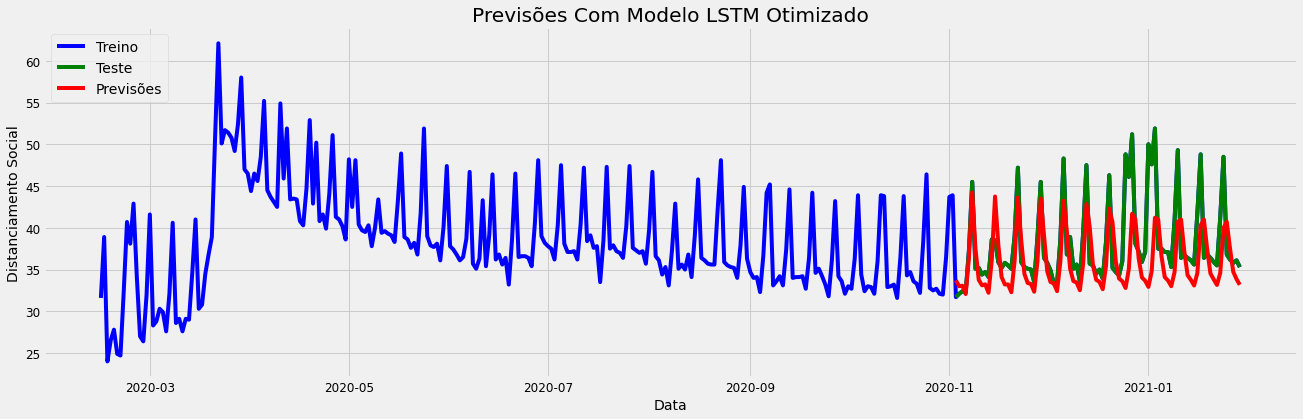

In [28]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(target.index, target.values, label = 'Treino', color = 'Blue')
plt.plot(teste, label = 'Teste', color = 'green')

# Previsões
plt.plot(target[262:].index, resultado_final, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo LSTM Otimizado')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend(loc = 'upper left')
plt.show()

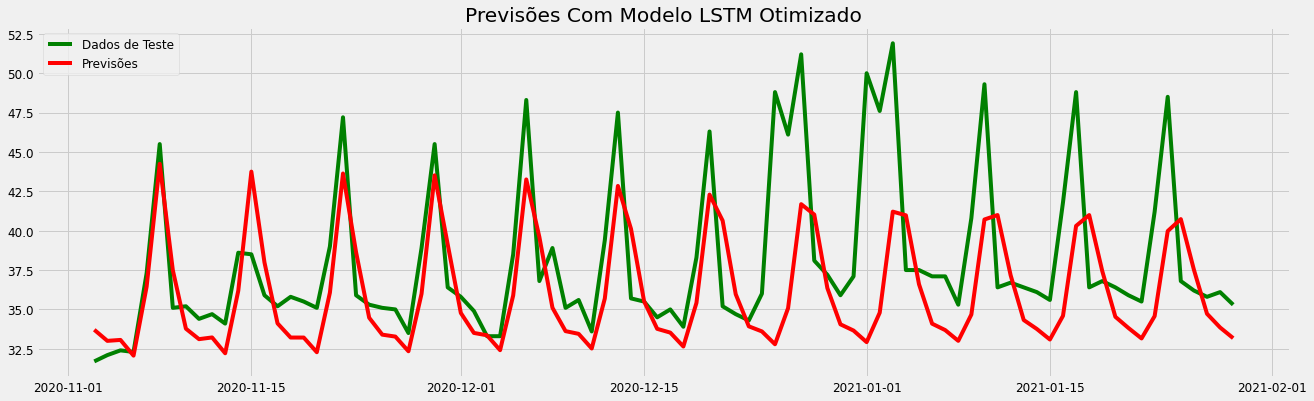

In [29]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[262:].index, resultado_final, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Otimizado')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Vamos fazer o Forecasting para 2 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [30]:
# Última data da série
target.index[-1]

Timestamp('2021-01-29 00:00:00')

In [31]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 89)]

In [32]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [33]:
# Nossa série original é um objeto do tipo pd.Series
#type(target)

In [34]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [35]:
# Visualiza os dados
#df_original.head()

In [36]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [37]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
#data_futuras

In [38]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [39]:
# Concatenamos a série original com os valores de forecasting de 139 semanas além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [40]:
# Visualiza o dataframe
df_forecasting

,QT_INTER,Prediction
2020-02-15,31.6,NaN
2020-02-16,38.9,NaN
2020-02-17,24.0,NaN
2020-02-18,26.5,NaN
2020-02-19,27.8,NaN
...,...,...
2021-04-23,NaN,38.304428
2021-04-24,NaN,37.644834
2021-04-25,NaN,37.594317
2021-04-26,NaN,38.151950


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste. 
Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 2 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Vamos colocar o forecasting em um Plot.

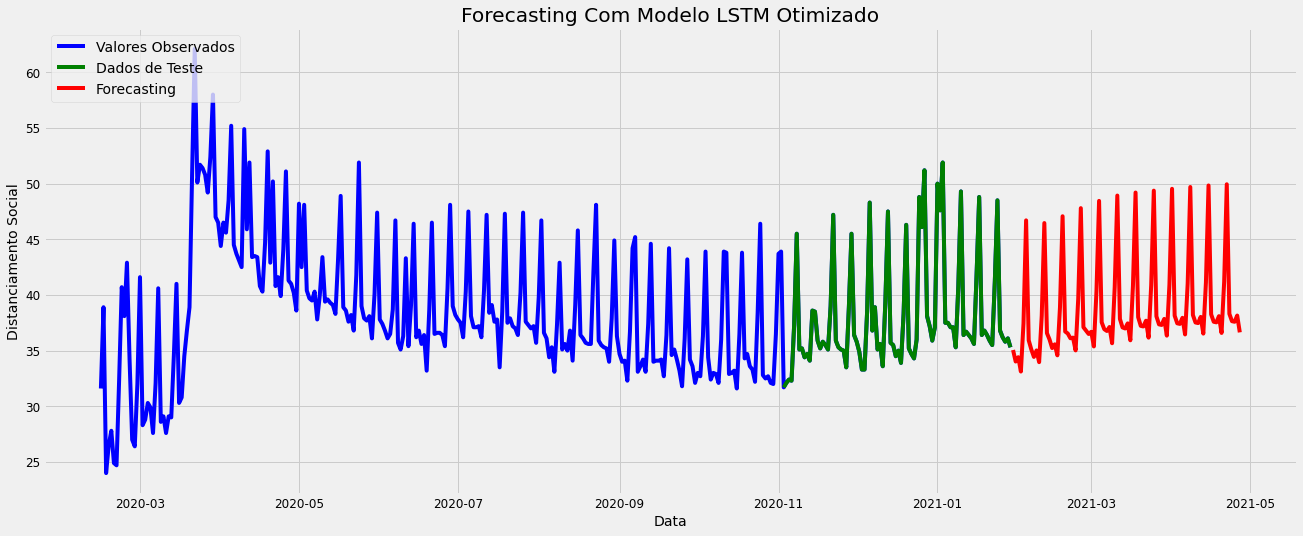

In [42]:
# Plot
plt.figure(figsize = (20, 8))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Otimizado')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend(loc = 'upper left')
plt.show()

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (9, 6) - AIC = 1295.100 e RMSE = 3.5966
- Modelo 16 --> Modelo ARIMA Forcast (4, 1, 5) Forecast - AIC = 1385.134 e RMSE = 3.7513
- Modelo 17 --> Modelo SARIMA (2, 1, 1)x(2, 1, 0, 10) - AIC = 1449.398 e RMSE = 6.5842
- Modelo 18 --> Modelo SARIMA (1, 1, 1)x(0, 1, 1, 10) - AIC = 1451.114 e RMSE = 5.0104
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 10.1241 e RMSE = 3.8363   -   (3 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 10.6874 e RMSE = 5.9767   -   (5 repetições)
- Modelo 23 --> Modelo Stacked LSTM - MAPE = 7.9989 e RMSE = 4.6203   -   (5 repetições)

Vamos seguir otimizando nossa rede LSTM e ver até onde conseguimos ir com essa arquitetura.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim